In this notebook, we will try to train a XGBoost model using permissions from android applications.

<h1>Loading Data</h1>

<h1>Regular Run Start</h1>
Up from here, you can find the necessary code to prepare the data to train using Permissions.
For convenience, here on out we will use the already exported data.

In [146]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Read the CSV file
df = pd.read_csv('permissions_labeled_dataset.csv')
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df['detection'].value_counts()

detection
trojan        7793
adware        4545
benign        4296
other          766
hacktool       261
spyware        255
exploit        222
rootkit         43
ransomware       5
Name: count, dtype: int64

In [147]:
df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'rootkit']
df = df[df['detection'] != 'other']

benign_samples = df[df['detection'] == 'benign'].sample(n=1000, random_state=42)
trojan_samples = df[df['detection'] == 'trojan'].sample(n=400, random_state=42)
adware_samples = df[df['detection'] == 'adware'].sample(n=300, random_state=42)
spyware_samples = df[df['detection'] == 'spyware'].sample(n=250, random_state=42)
other_samples = df[(df['detection'] != 'benign') & (df['detection'] != 'trojan') & (df['detection'] != 'adware') & (df['detection'] != 'spyware')].groupby('detection').apply(lambda x: x.sample(n=min(200, len(x)), random_state=42)).reset_index(drop=True)
df = pd.concat([benign_samples, other_samples, trojan_samples, adware_samples, spyware_samples]).reset_index(drop=True)
df['detection'].value_counts()

/tmp/ipykernel_281257/303442821.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_samples = df[(df['detection'] != 'benign') & (df['detection'] != 'trojan') & (df['detection'] != 'adware') & (df['detection'] != 'spyware')].groupby('detection').apply(lambda x: x.sample(n=min(200, len(x)), random_state=42)).reset_index(drop=True)


detection
benign      1000
trojan       400
adware       300
spyware      250
exploit      200
hacktool     200
Name: count, dtype: int64

In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('./fine-tuned_models/xgb/catch_o_ware_data-permissions.csv')

df['detection'].value_counts()



detection
benign      1000
trojan       400
adware       300
spyware      250
exploit      200
hacktool     200
Name: count, dtype: int64

In [151]:
# Separate features and labels
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [152]:
# Encode string labels into numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



<h1>Training the XGBoost Classifier</h1>

In [43]:
# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(
    eval_metric='mlogloss', 
    random_state=42, 
    colsample_bytree=1.0, 
    learning_rate=0.1, 
    max_depth=9, 
    min_child_weight=2, 
    n_estimators=1000, 
    subsample=0.7, 
    eta=0.1, 
    n_jobs=-1
)

In [44]:
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-mlogloss:1.59931
[1]	validation_0-mlogloss:1.44274


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:40:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "retrieve_best", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-mlogloss:1.31672
[3]	validation_0-mlogloss:1.21010
[4]	validation_0-mlogloss:1.12041
[5]	validation_0-mlogloss:1.04078
[6]	validation_0-mlogloss:0.97127
[7]	validation_0-mlogloss:0.91202
[8]	validation_0-mlogloss:0.85665
[9]	validation_0-mlogloss:0.80974
[10]	validation_0-mlogloss:0.76642
[11]	validation_0-mlogloss:0.72571
[12]	validation_0-mlogloss:0.68980
[13]	validation_0-mlogloss:0.66018
[14]	validation_0-mlogloss:0.63185
[15]	validation_0-mlogloss:0.60549
[16]	validation_0-mlogloss:0.58196
[17]	validation_0-mlogloss:0.56043
[18]	validation_0-mlogloss:0.54113
[19]	validation_0-mlogloss:0.52233
[20]	validation_0-mlogloss:0.50568
[21]	validation_0-mlogloss:0.48922
[22]	validation_0-mlogloss:0.47454
[23]	validation_0-mlogloss:0.46101
[24]	validation_0-mlogloss:0.44989
[25]	validation_0-mlogloss:0.43914
[26]	validation_0-mlogloss:0.42892
[27]	validation_0-mlogloss:0.41938
[28]	validation_0-mlogloss:0.41105
[29]	validation_0-mlogloss:0.40344
[30]	validation_0-mlogloss:0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, ...)

<h1> Hyperparameter Tuning </h1>

In [8]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'max_depth': [7, 9, 11],
    'min_child_weight': [2, 4, 6],
}

# Create the XGBoost model object
xgb_clf = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', verbose=3)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.875 total time=   5.1s
[CV 2/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.883 total time=   4.4s
[CV 3/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.848 total time=   4.3s
[CV 4/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.883 total time=   4.7s
[CV 5/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.5;, score=0.878 total time=   4.8s
[CV 1/5] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, n_estimators=50, subsample=0.7;, score=0.870 total time=   5.1s
[CV 2/5] END colsample_bytree=

In [9]:
# Evaluate top10 parameter sets
results_df = pd.DataFrame(grid_search.cv_results_)
top_params = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'mean_fit_time']]
print(top_params)

                                                params  mean_test_score  \
358  {'colsample_bytree': 1.0, 'learning_rate': 0.1...         0.906915   
62   {'colsample_bytree': 0.5, 'learning_rate': 0.1...         0.905851   
35   {'colsample_bytree': 0.5, 'learning_rate': 0.1...         0.904255   
224  {'colsample_bytree': 0.7, 'learning_rate': 0.1...         0.904255   
385  {'colsample_bytree': 1.0, 'learning_rate': 0.1...         0.904255   
331  {'colsample_bytree': 1.0, 'learning_rate': 0.1...         0.903191   
197  {'colsample_bytree': 0.7, 'learning_rate': 0.1...         0.902660   
359  {'colsample_bytree': 1.0, 'learning_rate': 0.1...         0.902660   
386  {'colsample_bytree': 1.0, 'learning_rate': 0.1...         0.902660   
196  {'colsample_bytree': 0.7, 'learning_rate': 0.1...         0.902128   

     mean_fit_time  
358      21.683342  
62       30.713833  
35       19.236748  
224      19.241480  
385      18.876219  
331      16.998048  
197      14.865140  
359   

<h1> Evaluate Model Performance </h1>

In [55]:
df['detection'].value_counts()

detection
benign      1000
trojan       400
adware       300
spyware      250
exploit      200
hacktool     200
Name: count, dtype: int64

In [122]:
# Generate predictions
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
val_loss = xgb_clf.evals_result()['validation_0']['mlogloss'][-1]
print(f'Validation Loss: {val_loss}')

# Print the classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.9382978723404255
Validation Loss: 0.21453050512694236
              precision    recall  f1-score   support

      adware       0.91      0.89      0.90        56
      benign       0.96      0.97      0.96       206
     exploit       0.90      0.90      0.90        41
    hacktool       0.92      0.97      0.95        36
     spyware       0.96      0.98      0.97        47
      trojan       0.92      0.87      0.90        84

    accuracy                           0.94       470
   macro avg       0.93      0.93      0.93       470
weighted avg       0.94      0.94      0.94       470



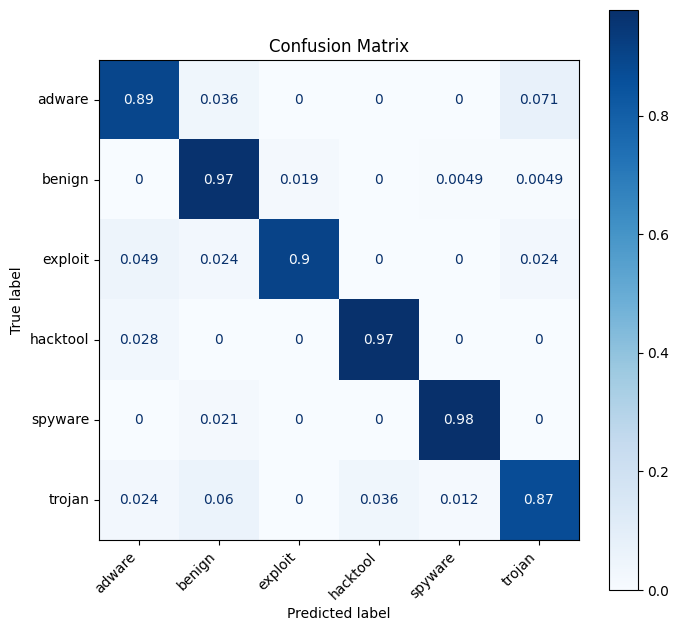

In [124]:
# Create confusion matrix display
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test, display_labels=label_encoder.classes_, cmap=plt.cm.Blues, normalize='true', ax=ax)

# Adjust label positions
plt.xticks(rotation=45, ha='right')
plt.yticks(va='center')

# Add some padding between the plot and the labels
plt.subplots_adjust(bottom=0.3, left=0.3)

plt.title("Confusion Matrix")
plt.show()

In [58]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Generate predicted probabilities
y_pred_proba = xgb_clf.predict_proba(X_test)

# Binarize the output
classes = label_encoder.classes_
y_test_bin = label_binarize(y_test, classes=range(len(classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


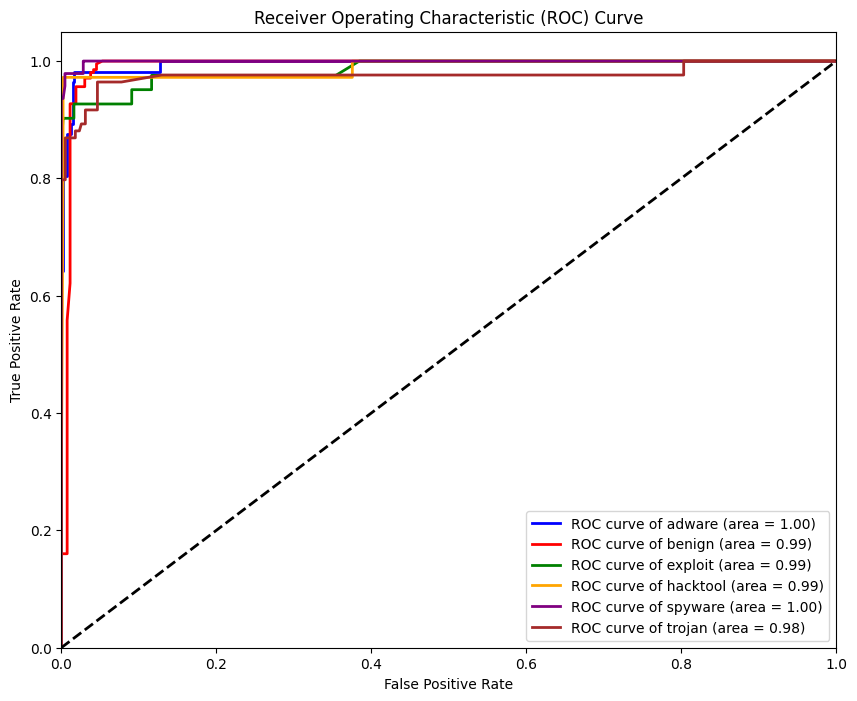

In [59]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
for i, color, cls in zip(range(len(classes)), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {cls} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


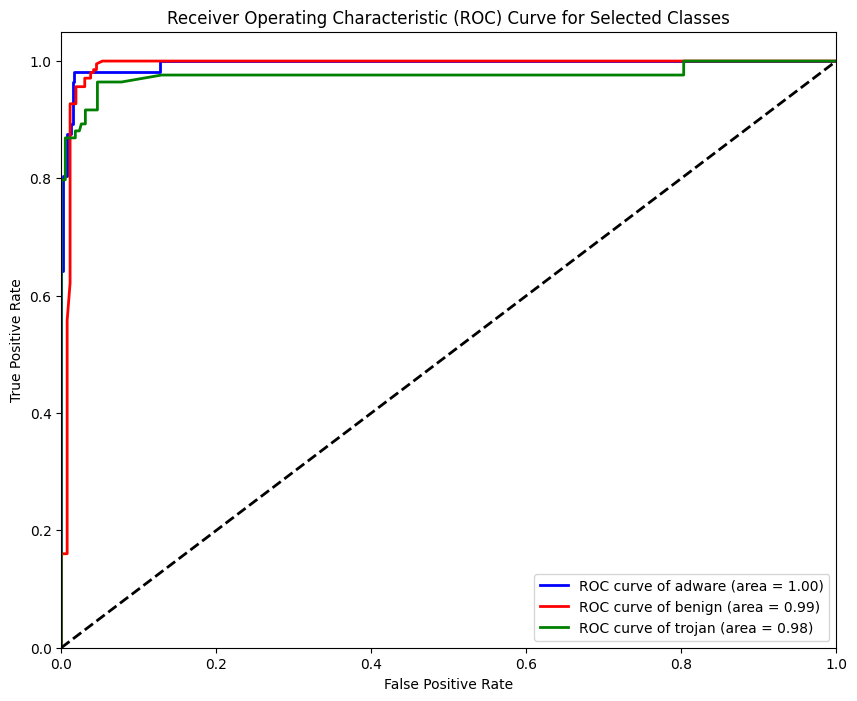

In [60]:
# Plot ROC curves for selected classes
selected_classes = ['adware', 'benign', 'trojan']  # Example of selected classes
colors = ['blue', 'red', 'green']
plt.figure(figsize=(10, 8))
for i, cls in enumerate(selected_classes):
    idx = list(label_encoder.classes_).index(cls)
    plt.plot(fpr[idx], tpr[idx], color=colors[i], lw=2, label=f'ROC curve of {cls} (area = {roc_auc[idx]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Selected Classes')
plt.legend(loc="lower right")
plt.show()


In [61]:
from sklearn.metrics import hamming_loss, balanced_accuracy_score, cohen_kappa_score

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)

# Hamming Loss
hamming = hamming_loss(y_test, y_pred)

# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Cohen's Kappa: {kappa}")
print(f"Hamming Loss: {hamming}")
print(f"Balanced Accuracy: {balanced_acc}")

Cohen's Kappa: 0.9162904959312145
Hamming Loss: 0.06170212765957447
Balanced Accuracy: 0.9310271998633857


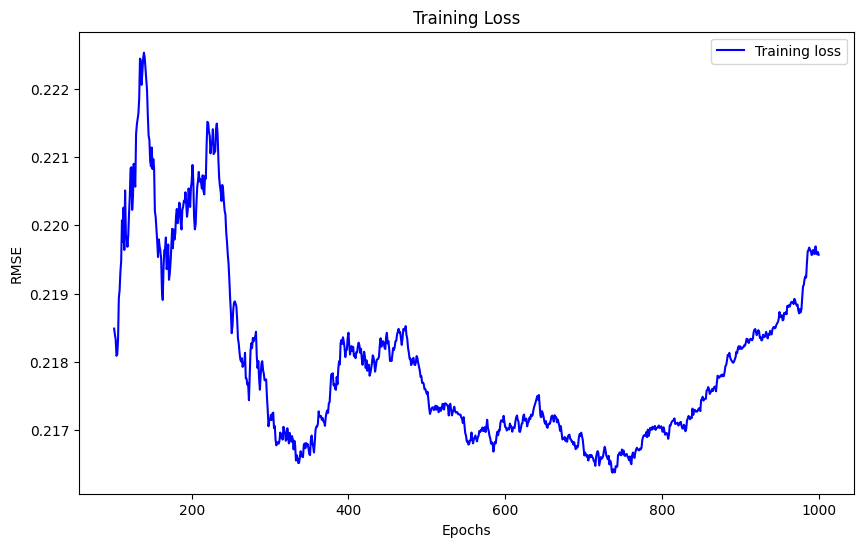

In [136]:
import matplotlib.pyplot as plt

# Extract the training and validation loss from the evals_result
train_loss = xgb_clf.evals_result()['validation_0']['mlogloss'][100:]

# Create a range of epochs
epochs = range(101, len(train_loss) + 101)
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()


In [153]:
from sklearn.model_selection import cross_val_score

xgb_clf = joblib.load('./fine-tuned_models/xgb/xgb_fine-tune-1.joblib')

# Perform cross-validation
cv_scores = cross_val_score(xgb_clf, X, y_encoded, cv=5, scoring='accuracy', verbose=3)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV scores:", cv_scores.std())


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.864) total time= 6.9min


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:26:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.874) total time= 1.1min


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:27:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.879) total time=  48.2s


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.877) total time=  43.3s


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:29:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.862) total time=  45.0s
Cross-validation scores: [0.86382979 0.87446809 0.8787234  0.87659574 0.86170213]
Mean CV score: 0.8710638297872342
Standard deviation of CV scores: 0.0069402155022553645


In [154]:
from sklearn.model_selection import cross_val_score

xgb_clf = joblib.load('./fine-tuned_models/xgb/xgb_fine-tune-2.joblib')
# Perform cross-validation
cv_scores = cross_val_score(xgb_clf, X, y_encoded, cv=5, scoring='accuracy', verbose=3)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
print("Standard deviation of CV scores:", cv_scores.std())


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:29:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "retrieve_best", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.862) total time= 1.1min


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:31:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "retrieve_best", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.877) total time= 1.1min


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:32:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "retrieve_best", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.883) total time= 1.1min


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:33:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "retrieve_best", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.881) total time= 1.1min


/home/kreunt/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:34:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "retrieve_best", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ................................ score: (test=0.864) total time= 1.1min
Cross-validation scores: [0.86170213 0.87659574 0.88297872 0.88085106 0.86382979]
Mean CV score: 0.873191489361702
Standard deviation of CV scores: 0.00878287976193631


In [63]:
import joblib

joblib.dump(xgb_clf, 'xgb_model.joblib')
print("Model saved successfully.")


Model saved successfully.


In [134]:
import joblib

# Load the trained XGB model
xgb_clf = joblib.load('./fine-tuned_models/xgb/xgb_fine-tune-1.joblib')